### Optimizing the Latent Space of Generative Networks
https://arxiv.org/pdf/1707.05776.pdf

In [1]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./gdrive


In [2]:
cd ./gdrive/My\ Drive/Colab Notebooks/

/content/gdrive/My Drive/Colab Notebooks


In [0]:
from tqdm import tqdm
import numpy as np
import os
import re
import shutil
from PIL import Image
from skimage import io


import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import SGD, Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.core.debugger import set_trace

from sklearn.manifold import Isomap, TSNE, MDS

SORTING_KEY = lambda x: int( re.findall('\d+' ,x)[0])

# Datasets

In [0]:
SIZE = 64

class DynTexDataset(Dataset):
  
    def __init__(self, root_dir, texture_names, seq_len = 4, loss_len = 3, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.texture_names = texture_names
        self.seq_len = seq_len
        self.loss_len = loss_len
        self.indx_texture_sequence = []
        self.path2indx = {}
        
        # let each image has unique index
        i = 0
        for texture_name in texture_names:
            texture_fold = os.path.join(root_dir, texture_name)
            for img_name in sorted(os.listdir(texture_fold), key=SORTING_KEY):
                self.path2indx[os.path.join(texture_fold, img_name)] = i
                i += 1
        
        # indicate all sequences
        for name in texture_names:
            texture_fold = os.path.join(root_dir, name)
            n_framesets = len(os.listdir(texture_fold)) - (seq_len + loss_len) + 1
            if n_framesets <= 0:
                continue
            for j in range(n_framesets):
                # j - number of the sequence
                # texture_fold - fold of the seq
                self.indx_texture_sequence.append([texture_fold, j])
    
    def get_seq(self, fold, seq_len, loss_len, i, cat_dim = 0):
      
        '''
        Returns tensor-sequense
        '''
        transforms = Compose([Resize((SIZE,SIZE)), ToTensor()])

        names = sorted(os.listdir(fold), key = SORTING_KEY)

        seq_imgs = []
        loss_imgs = []
        seq_indices = []
        loss_indices = []

        assert len(names[i+seq_len:i+seq_len+loss_len]) == loss_len
        for name in names[i+seq_len:i+seq_len+loss_len]:

          image_path = os.path.join(fold, name)
          img = Image.open(image_path)
          img_trasformed = transforms(img)
          loss_imgs += [img_trasformed.unsqueeze(cat_dim)]
          loss_indices += [self.path2indx[image_path]]

        assert len(names[i:i+seq_len]) == seq_len
        for name in names[i:i+seq_len]:

          image_path = os.path.join(fold, name)
          img = Image.open(image_path)
          img_trasformed = transforms(img)
          seq_imgs += [img_trasformed.unsqueeze(cat_dim)]
          seq_indices += [self.path2indx[image_path]]

        seq_imgs = torch.cat(seq_imgs, cat_dim)
        loss_imgs = torch.cat(loss_imgs, cat_dim)

        return seq_imgs, loss_imgs, torch.tensor(seq_indices), torch.tensor(loss_indices)
    
    
    def __getitem__(self, idx):
        
        fold, i = self.indx_texture_sequence[idx]
        return self.get_seq(fold, self.seq_len, self.loss_len, i)

    def __len__(self):

        return len(self.indx_texture_sequence)

          
def deprocess(img_tensor):

    img = img_tensor[0].detach().cpu().numpy().transpose(1,2,0)

    img= np.clip(img, 0., 1.)

    return  img  
 

In [0]:
'''
Code below was taken from 
https://github.com/nathbo/generative-latent-optimization/blob/master/utils.py
'''

def gaussian(x, sigma=1.0):
    return np.exp(-(x**2) / (2*(sigma**2)))


def build_gauss_kernel(
        size=5, sigma=1.0, n_channels=1, device=None):
    """Construct the convolution kernel for a gaussian blur
    See https://en.wikipedia.org/wiki/Gaussian_blur for a definition.
    Overall I first generate a NxNx2 matrix of indices, and then use those to
    calculate the gaussian function on each element. The two dimensional
    Gaussian function is then the product along axis=2.
    Also, in_channels == out_channels == n_channels
    """
    if size % 2 != 1:
        raise ValueError("kernel size must be uneven")
    grid = np.mgrid[range(size), range(size)] - size//2
    kernel = np.prod(gaussian(grid, sigma), axis=0)
    # kernel = np.sum(gaussian(grid, sigma), axis=0)
    kernel /= np.sum(kernel)

    # repeat same kernel for all pictures and all channels
    # Also, conv weight should be (out_channels, in_channels/groups, h, w)
    kernel = np.tile(kernel, (n_channels, 1, 1, 1))
    kernel = torch.from_numpy(kernel).to(torch.float).to(device)
    return kernel


def blur_images(images, kernel):
    """Convolve the gaussian kernel with the given stack of images"""
    _, n_channels, _, _ = images.shape
    _, _, kw, kh = kernel.shape
    imgs_padded = F.pad(images, (kw//2, kh//2, kw//2, kh//2), mode='replicate')
    return F.conv2d(imgs_padded, kernel, groups=n_channels)


def laplacian_pyramid(images, kernel, max_levels=5):
    """Laplacian pyramid of each image
    https://en.wikipedia.org/wiki/Pyramid_(image_processing)#Laplacian_pyramid
    """
    current = images
    pyramid = []

    for level in range(max_levels):
        filtered = blur_images(current, kernel)
        diff = current - filtered
        pyramid.append(diff)
        current = F.avg_pool2d(filtered, 2)
    pyramid.append(current)
    return pyramid


class LapLoss(nn.Module):
    def __init__(self, max_levels=5, kernel_size=5, sigma=1.0):
        super(LapLoss, self).__init__()
        self.max_levels = max_levels
        self.kernel_size = kernel_size
        self.sigma = sigma
        self._gauss_kernel = None

    def forward(self, output, target):
        if (self._gauss_kernel is None
                or self._gauss_kernel.shape[1] != output.shape[1]):
            self._gauss_kernel = build_gauss_kernel(
                n_channels=output.shape[1],
                device=output.device)
        output_pyramid = laplacian_pyramid(
            output, self._gauss_kernel, max_levels=self.max_levels)
        target_pyramid = laplacian_pyramid(
            target, self._gauss_kernel, max_levels=self.max_levels)
        diff_levels = [F.l1_loss(o, t)
                        for o, t in zip(output_pyramid, target_pyramid)]
        loss = sum([2**(-2*j) * diff_levels[j]
                    for j in range(self.max_levels)])
        return loss

In [0]:
class TexureGenerator(nn.Module):
    '''
    was taken from here https://github.com/tneumann/minimal_glo/blob/master/glo.py
    '''
    def __init__(self, code_dim, n_filter=64, out_channels=3):
        super(TexureGenerator, self).__init__()
        
        self.code_dim = code_dim

        self.u_unconv1 = nn.ConvTranspose2d(code_dim, n_filter*2, (2,2), stride = 1, bias=True)
        self.u_conv1 = nn.Conv2d(n_filter*2, n_filter*2, (1,1), stride = 1, bias=True)

        self.u_unconv2 = nn.ConvTranspose2d(n_filter*2, n_filter*4, (2,2), stride = 2, bias=True)
        self.u_conv2= nn.Conv2d(n_filter*4, n_filter*4, (1,1), stride = 1, bias=True)

        self.u_unconv3 = nn.ConvTranspose2d(n_filter*4, n_filter*4, (4,4), stride = 4, bias=True)
        self.u_conv3 = nn.Conv2d(n_filter*4, n_filter*4, (1,1), stride = 1, bias=True)

        self.u_unconv4= nn.ConvTranspose2d(n_filter*4, n_filter*4, (4,4), stride = 4, bias=True)
        self.u_conv4 = nn.Conv2d(n_filter*4, 3, (1,1), stride = 1, bias=True)

        self.relu = nn.LeakyReLU()
        
    def forward(self, x):
      
        x = x.view(x.size(0), self.code_dim, 1, 1)
        
        x = self.u_unconv1(x)
        x = self.u_conv1(x)
        x = self.relu(x)
        
        x = self.u_unconv2(x)
        x = self.u_conv2(x)
        x = self.relu(x)

        x = self.u_unconv3(x)
        x = self.u_conv3(x)
        x = self.relu(x)
        
        x = self.u_unconv4(x)
        x = self.u_conv4(x)
        x = self.relu(x)  

        return x
      
      
class LatentLSTM(nn.Module):
    def __init__(self, code_dim, hidden_size = 512):
        super(LatentLSTM, self).__init__()
        
        '''
        maps sequence of vectors into vector from the same dim
        '''
        
        self.lstm = nn.LSTM(code_dim, code_dim, batch_first = True)
        
    def forward(self, x):
        
        '''
        x - [batch_size, seq_len, code_dim]
        '''
      
        out, _ = self.lstm(x)
        return out[:,-1:,].squeeze(1)  
      
class LatentLSTM_v2(nn.Module):
    def __init__(self, code_dim, hidden_size = 512):
        super(LatentLSTM_v2, self).__init__()
        
        '''
        maps sequence of vectors into vector from the same dim
        '''
        
        self.lstm = nn.LSTM(code_dim, code_dim, batch_first = True, num_layers = 2, dropout = 0.1)
        
    def forward(self, x):
        
        '''
        x - [batch_size, seq_len, code_dim]
        '''
        x 
        out, _ = self.lstm(x)
        return out[:,-1:,].squeeze(1)        
  

### Utils

In [0]:
def project_l2_ball(z):
    """ project the vectors in z onto the l2 unit norm ball
        was taken from here https://github.com/tneumann/minimal_glo/blob/master/glo.py
    """
    return z / np.maximum(np.sqrt(np.sum(z**2, axis=1))[:, np.newaxis], 1)      
       
  
def generate(latent_lstm, generator, z, N_gen = 10, save = True, fold_save = None):

    gen = []

    for i in range(1,N_gen+1):

        out = latent_lstm(z)
        if save:
            image_name = os.path.join(fold_save, '{}.jpg'.format(i))
            plt.figure()
            plt.imshow(deprocess(generator(out)))
            plt.title('step {}'.format(i))
            plt.savefig(image_name)
            files.download(image_name)  

        gen.append(out)
        z = torch.cat((z, out.unsqueeze(1)),1)
        z = z[:,1:,:]
    return gen        
        
def plot_diff(gen):
    diffs = []
    N_gen = len(gen)
    for i in range(1,N_gen):
        diffs += [(gen[i] - gen[i-1]).abs().sum().item()]
    
    plt.figure()
    plt.plot(diffs, 'r')
    plt.show()  

In [0]:
root_dir = './data/dynamic_textures/'

# texture_names = ['calm_water_1',
#                  'calm_water_2',
#                  'calm_water_3',
#                  'calm_water_4',
#                  'calm_water_5',
#                  'calm_water_6',
#                  'calm_water_7',
#                  'calm_water_8',
#                  'calm_water_9',
#                  'calm_water_10',
#                  'calm_water_11',
#                  'calm_water_12',
#                  'calm_water_13',
#                  'calm_water_14']

texture_names = ['calm_water_14']


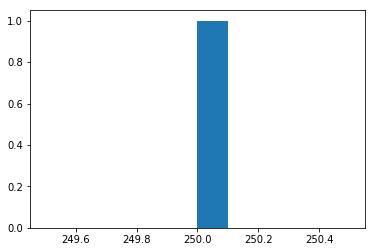

In [9]:
lens = []
for texture_name in texture_names:
    
    lens += [len(os.listdir(os.path.join(root_dir, texture_name)))]
plt.hist(lens)   

MIN_LEN = min(lens)

In [0]:
dt = 10
dl = 6
use_laploss = True
batch_size = 10

dataset = DynTexDataset(root_dir, texture_names, seq_len=dt, loss_len=dl)
train_gen = DataLoader(dataset,
                       batch_size = batch_size,
                       shuffle = False)



In [11]:
for x, y, i_x, i_y in train_gen:
    print (x.shape,y.shape, i_x.shape, i_y.shape)
    break

torch.Size([10, 10, 3, 64, 64]) torch.Size([10, 6, 3, 64, 64]) torch.Size([10, 10]) torch.Size([10, 6])


In [0]:
d = 512
generator = TexureGenerator(d, out_channels=3).cuda()

N = len(dataset.path2indx)
latent_variables = Variable(torch.randn((N, d), device="cuda"), requires_grad = True)
l2_loss = nn.MSELoss()
laploss = LapLoss()
optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)
z_optimizer = torch.optim.Adam([latent_variables], lr = 1e-3)

epoch_start = 1

In [0]:
# train_state = torch.load('./glo_l2_epoch500_ntxt1.pt')
# generator.load_state_dict(train_state['model_state_dict'])
# latent_variables = train_state['latent_varibles']
# rec_loss_history = train_state['rec_loss_history']

# plt.plot(rec_loss_history)
# plt.show()

# Train generator and latent vars

In [0]:
epochs = 300
freq_show = epochs//50
freq_save = 100

rec_loss_history = []
lstm_loss_history = []

for i in tqdm_notebook(range(epoch_start, epochs + 1)):
    for seq_batch, loss_batch, seq_indices, loss_indices in tqdm_notebook(train_gen):
        
        loss_indx = loss_indices.flatten().numpy()
        seq_indx = seq_indices.flatten().numpy()
        
        batch = torch.cat((seq_batch, loss_batch), 1).view(-1, 3, SIZE, SIZE).cuda()
        indices = np.concatenate((seq_indx, loss_indx), 0)
        
        assert indices.shape[0] == batch.shape[0]
        
        seq_batch = seq_batch.cuda()
    
        optimizer.zero_grad()
        z_optimizer.zero_grad()

        img_gen = generator(latent_variables[indices])      
        
        # reconstruction
        reconstruction_loss = l2_loss(img_gen, batch) + (laploss(img_gen, batch) if use_laploss else 0.)
        
        # penalize model for reconstruction
        reconstruction_loss.backward()
        optimizer.step()
        
        z_optimizer.step()
        
        latent_variables.data = torch.tensor(project_l2_ball(latent_variables.detach().cpu().numpy()), device='cuda')
        
        rec_loss_history.append(reconstruction_loss.detach().cpu().item())


    if i%freq_show == 0:        
        generator.eval()
        plt.figure()
        plt.imshow(deprocess(img_gen))
        plt.grid(False)  
        plt.title('epoch: {}'.format(i))
        plt.show()
        
        plt.figure()
        plt.plot(rec_loss_history)
        plt.show()

    if i% freq_save == 0:
        torch.save({
            'model_state_dict': generator.state_dict(),
            'latent_varibles':latent_variables,
            'optimizer_state_dict': optimizer.state_dict(),
            'z_optimizer':z_optimizer.state_dict(),
            'rec_loss_history': rec_loss_history,
            }, './glo_l2{0}_epoch{1}_ntxt{2}_dl{3}_dt{4}.pt'.format('lp' if use_laploss else '',
                                                                    i,
                                                                    len(texture_names),
                                                                    dl,
                                                                    dt))


# Train LSTM

In [0]:
# latent_lstm = LatentLSTM(d).cuda()

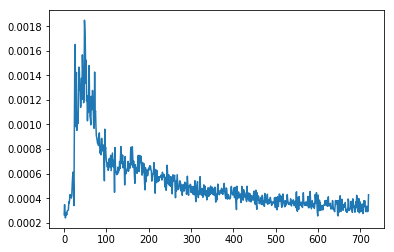

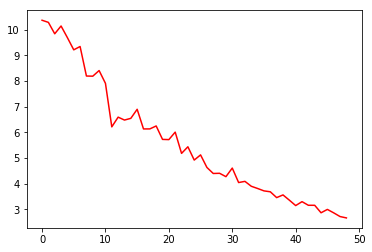

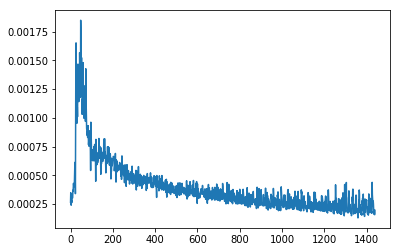

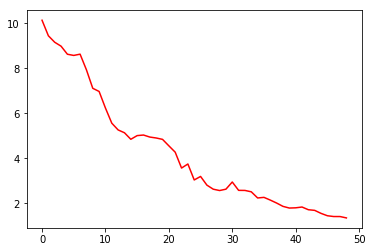

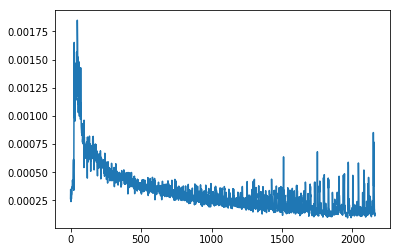

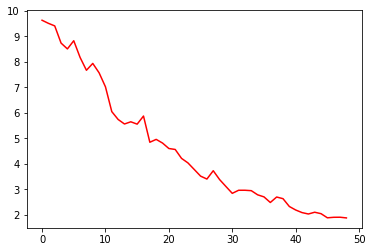

Saving...


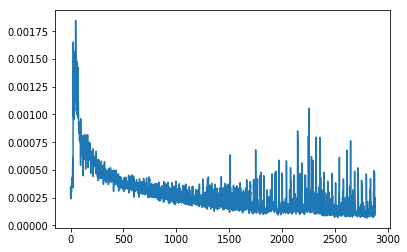

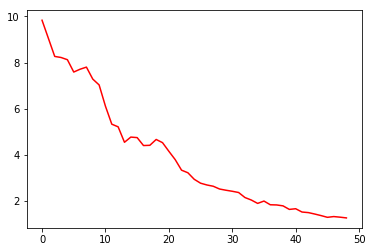

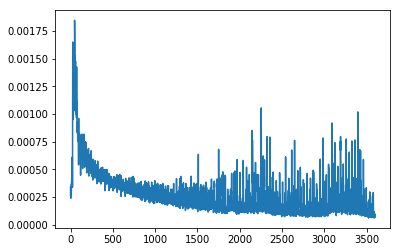

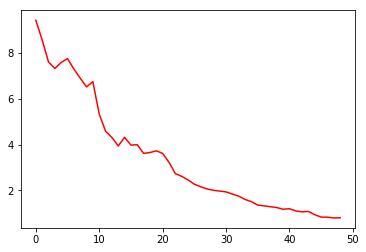

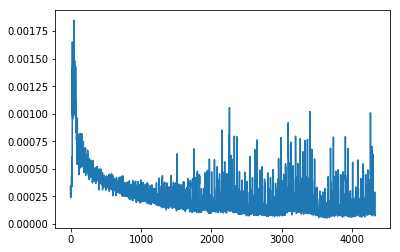

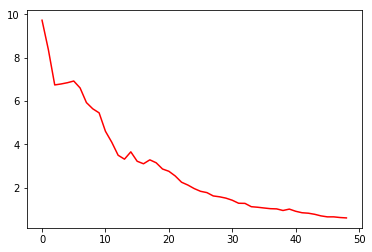

KeyboardInterrupt: ignored

In [31]:
lstm_optimizer = torch.optim.Adam(latent_lstm.parameters(), lr=1e-3)
latent_lstm.train()
epochs = 300
freq_show = epochs//10
freq_save = 100 #epochs + 1 #epochs//20

lstm_loss_history = []

for param in generator.parameters():
            param.requires_grad = False

for i in tqdm_notebook(range(1, epochs + 1)):
    for seq_batch, loss_batch, seq_indices, loss_indices in tqdm_notebook(train_gen):
        
        loss_indx = loss_indices.flatten().numpy()
        seq_indx = seq_indices.flatten().numpy()
        
        batch = torch.cat((seq_batch, loss_batch), 1).view(-1, 3, SIZE, SIZE).cuda()
        indices = np.concatenate((seq_indx, loss_indx), 0)
        
        seq_batch = seq_batch.cuda()

        lstm_optimizer.zero_grad()

        z = latent_variables[seq_indx].view(*seq_indices.shape, d)
        lstm_loss = 0
        for j, seq_iter in enumerate(range(loss_indices.shape[1])):
            loss_indx = loss_indices[:,seq_iter].flatten().numpy()
            z_loss = latent_variables[loss_indx].view(*loss_indices[:,seq_iter].shape, d)
            latent_predicted = latent_lstm(z)
            lstm_loss += l2_loss(latent_predicted, z_loss.squeeze())# * (1./(2**j))
            z = torch.cat((z, latent_predicted.unsqueeze(1)),1)
            z = z[:,1:,:]
        lstm_loss = lstm_loss / (j+1)
        
        # penalize vectors for reconstruction and lstm_loss
            
        lstm_loss.backward()
        lstm_optimizer.step()
        lstm_loss_history.append(lstm_loss)

    if i%freq_show == 0:                
        plt.figure()
        plt.plot(lstm_loss_history)
        plt.show()
        
        z = latent_variables[-dt:].unsqueeze(0)
        gen = generate(latent_lstm, generator, z, N_gen = 50, save = False)
        plot_diff(gen)

    if i% freq_save == 0:
        print ('Saving...')
        torch.save({
            'lstm_state_dict': latent_lstm.state_dict(),
            'lstm_optimizer_state_dict' : lstm_optimizer.state_dict(),
            'lstm_loss_history': lstm_loss_history,
            'generator': generator.state_dict(),
            'latent_variables': latent_variables,
            }, './lstm_finetune_l2{0}_epoch{1}_ntxt{2}_dl{3}_dt{4}.pt'.format('lp' if use_laploss else '',
                                                                     i,
                                                                     len(texture_names),
                                                                     dl,
                                                                     dt))


# Train LSTM and generator and latent vars simultaniously

In [0]:
d = 512 # simenslatent_variablesionality of the latent space
N = len(dataset.path2indx)
use_laploss = True

generator = TexureGenerator(d, out_channels=3).cuda()
latent_lstm = LatentLSTM(d).cuda()
latent_variables = Variable(torch.randn((N, d), device="cuda"), requires_grad = True)

l2_loss = nn.MSELoss()
laploss = LapLoss()

optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)
z_optimizer = torch.optim.Adam([latent_variables], lr = 1e-4)
lstm_optimizer = torch.optim.Adam(latent_lstm.parameters(), lr=1e-4)

epoch_start = 1


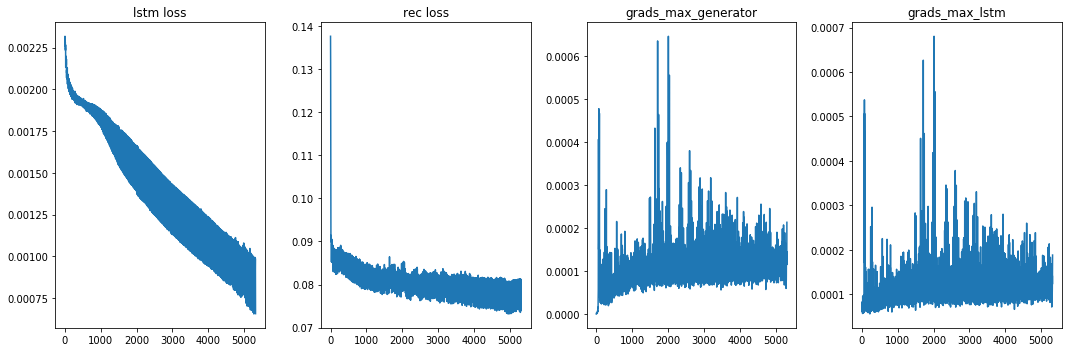

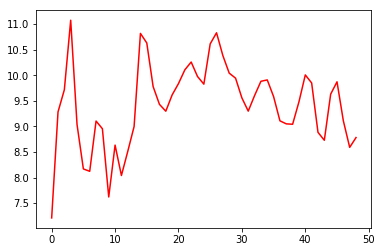

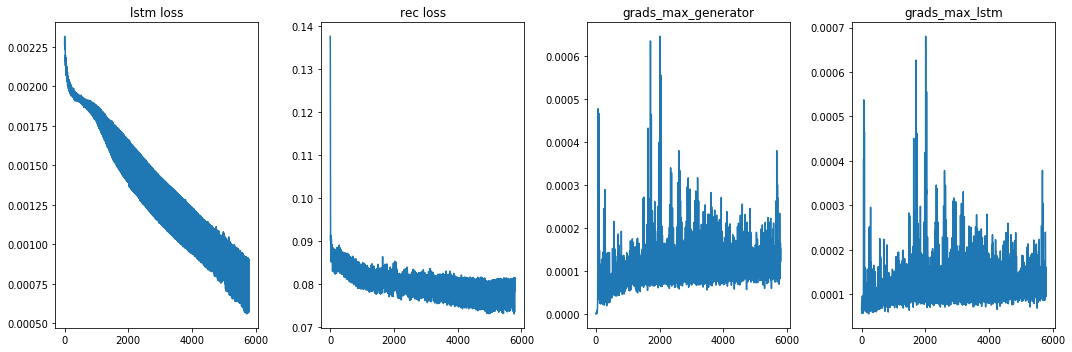

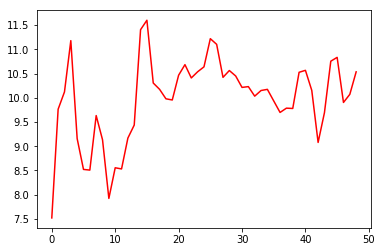

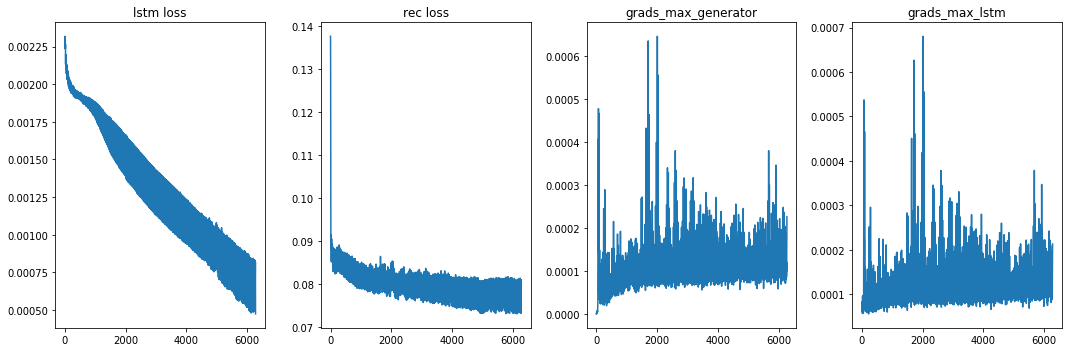

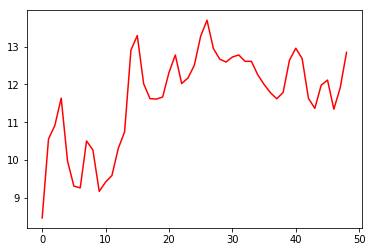

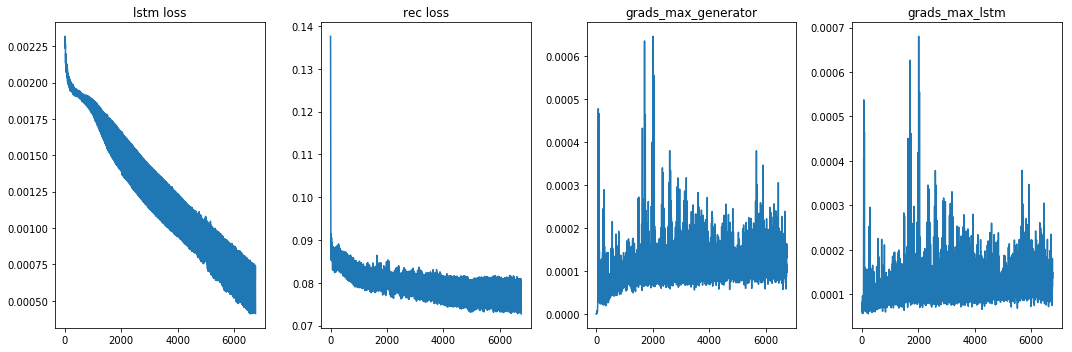

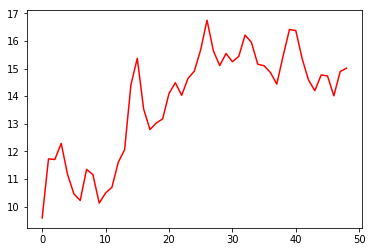

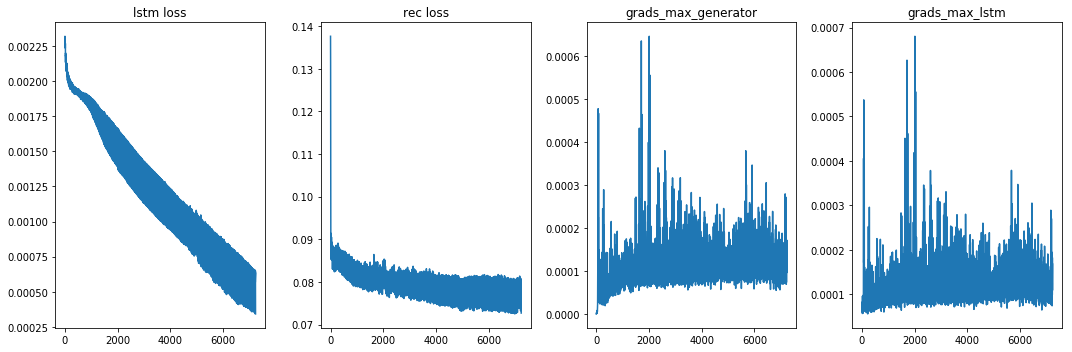

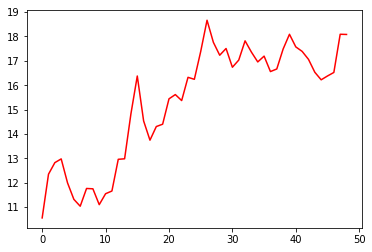

Saving...


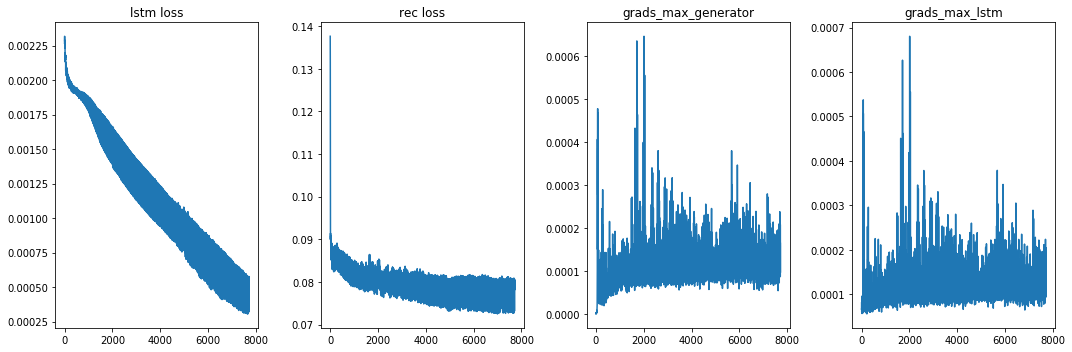

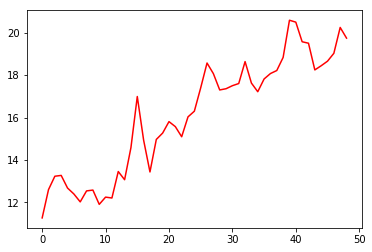

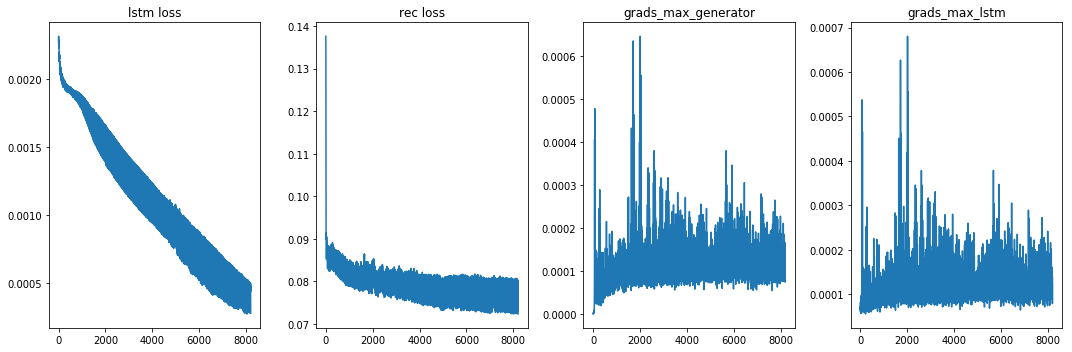

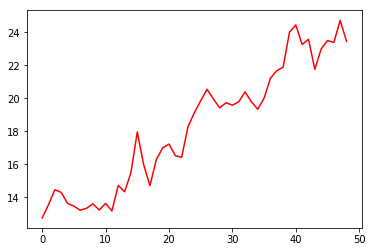

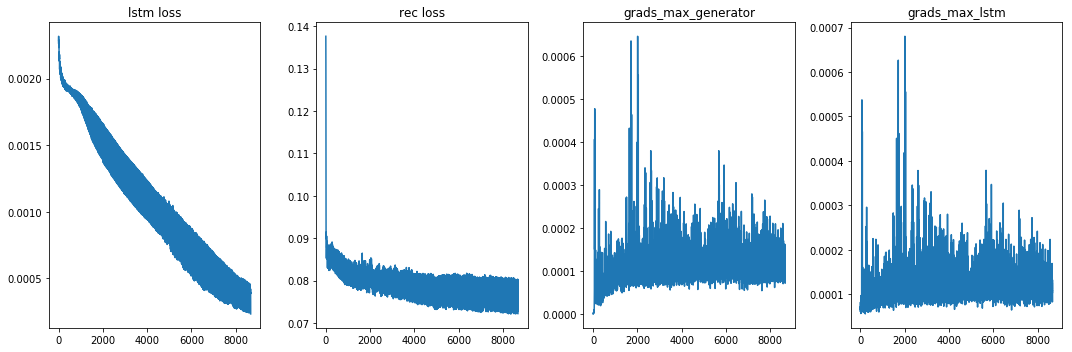

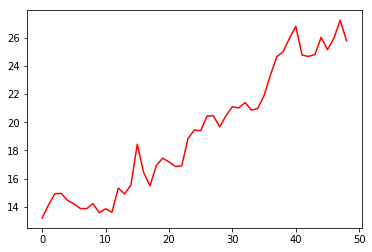

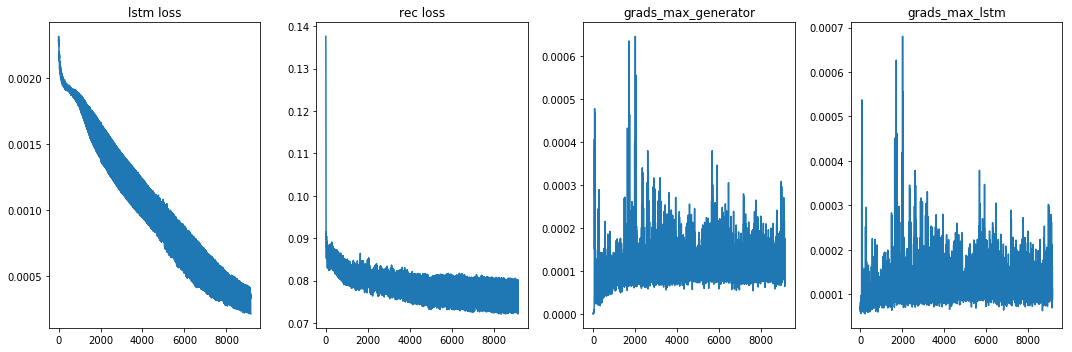

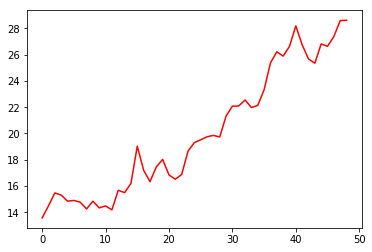

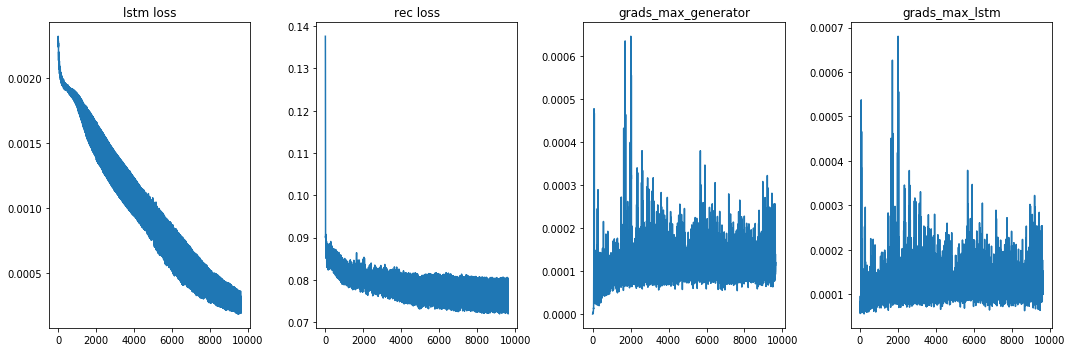

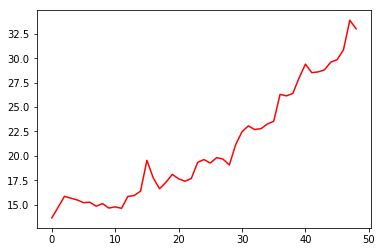

Saving...


In [27]:
epochs = 400
freq_show = 20 #epochs//10
freq_save = 100 #epochs + 1 #epochs//20

# lstm_loss_history = []
# rec_loss_history = []
# grads_max_lstm = []
# grads_max_generator = []


for i in tqdm_notebook(range(201, epochs + 1)):
    for seq_batch, loss_batch, seq_indices, loss_indices in tqdm_notebook(train_gen):
        
        loss_indx = loss_indices.flatten().numpy()
        seq_indx = seq_indices.flatten().numpy()
        
        batch = torch.cat((seq_batch, loss_batch), 1).view(-1, 3, SIZE, SIZE).cuda()
        indices = np.concatenate((seq_indx, loss_indx), 0)
        assert indices.shape[0] == batch.shape[0]

        seq_batch = seq_batch.cuda()
        
        optimizer.zero_grad()
        z_optimizer.zero_grad()
        lstm_optimizer.zero_grad()
        
        img_gen = generator(latent_variables[indices])
        reconstruction_loss = 0.5*l2_loss(img_gen, batch) + (laploss(img_gen, batch) if use_laploss else 0.)
        reconstruction_loss.backward()
        optimizer.step()

#         set_trace()
        grad_max = latent_variables.grad.abs().max().item()
        grads_max_generator.append(grad_max)
        z_optimizer.step()
        
        
        z = latent_variables[seq_indx].view(*seq_indices.shape, d)
        lstm_loss = 0
        for j, seq_iter in enumerate(range(loss_indices.shape[1])):
            loss_indx = loss_indices[:,seq_iter].flatten().numpy()
            z_loss = latent_variables[loss_indx].view(*loss_indices[:,seq_iter].shape, d)
            latent_predicted = latent_lstm(z)
            lstm_loss += l2_loss(latent_predicted, z_loss.squeeze())# * (1./(2**j))
            z = torch.cat((z, latent_predicted.unsqueeze(1)),1)
            z = z[:,1:,:]
        lstm_loss = lstm_loss / (j+1)
        
        # penalize vectors for reconstruction and lstm_loss
        lstm_loss.backward()
        lstm_optimizer.step()
        
#         set_trace()
        grad_max = latent_variables.grad.abs().max().item()
        grads_max_lstm.append(grad_max)
        latent_variables.grad = latent_variables.grad * 1e-9
        z_optimizer.step()
        
        # history
        lstm_loss_history.append(lstm_loss)
        rec_loss_history.append(reconstruction_loss.detach().cpu().item())
        
        latent_variables.data = torch.tensor(project_l2_ball(latent_variables.detach().cpu().numpy()), device='cuda')

    if i%freq_show == 0:                
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols =4, nrows = 1, figsize = (15,5))
        ax1.plot(lstm_loss_history)
        ax1.set_title('lstm loss')
        
        ax2.plot(rec_loss_history)
        ax2.set_title('rec loss')
        
        ax3.plot(grads_max_generator)
        ax3.set_title('grads_max_generator')
        
        ax4.plot(grads_max_lstm)
        ax4.set_title('grads_max_lstm')
        plt.tight_layout()
        plt.show()
        
        z = latent_variables[-dt:].unsqueeze(0)
        gen = generate(latent_lstm, generator, z, N_gen = 50, save = False)
        plot_diff(gen)

    if i% freq_save == 0:
        print ('Saving...')
        torch.save({
            'lstm_state_dict': latent_lstm.state_dict(),
            'lstm_optimizer_state_dict' : lstm_optimizer.state_dict(),
            'lstm_loss_history': lstm_loss_history,
            'model_state_dict': generator.state_dict(),
            'latent_varibles':latent_variables,
            'optimizer_state_dict': optimizer.state_dict(),
            'z_optimizer':z_optimizer.state_dict(),
            'rec_loss_history': rec_loss_history,
            }, './glo&lstm_l2{0}_epoch{1}_ntxt{2}_dl{3}_dt{4}.pt'.format('lp' if use_laploss else '',
                                                                         i,
                                                                         len(texture_names),
                                                                         dl,
                                                                         dt))


# Generate

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


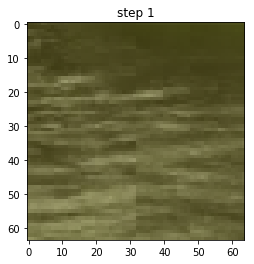

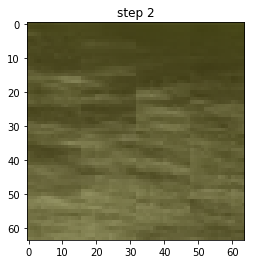

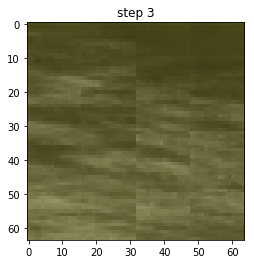

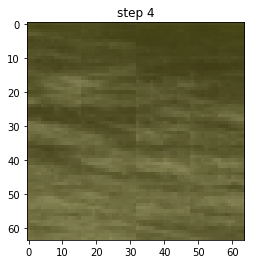

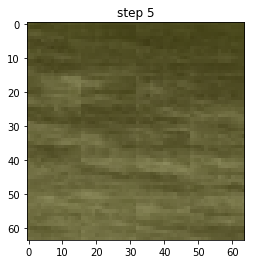

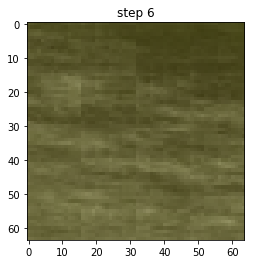

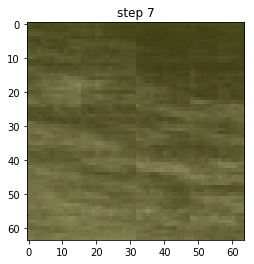

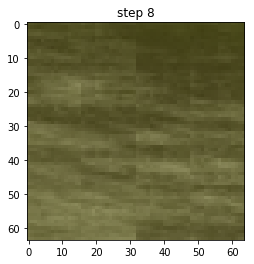

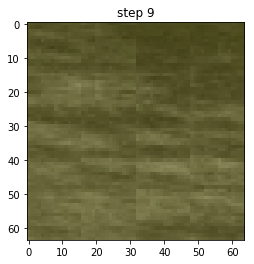

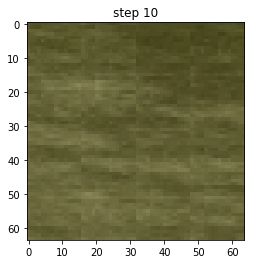

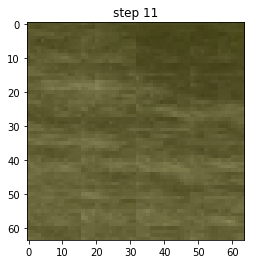

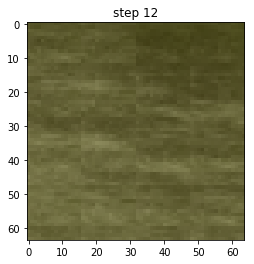

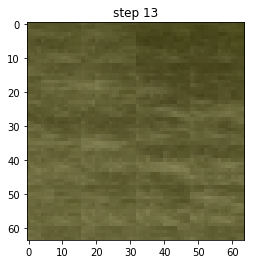

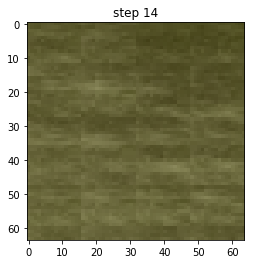

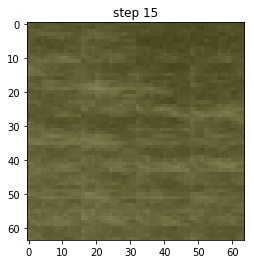

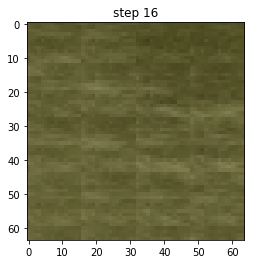

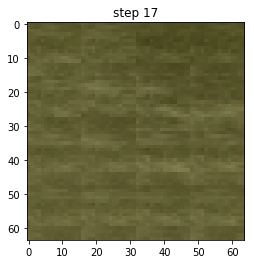

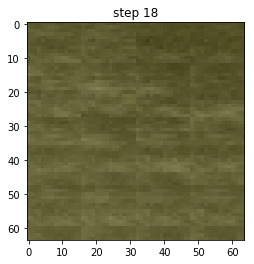

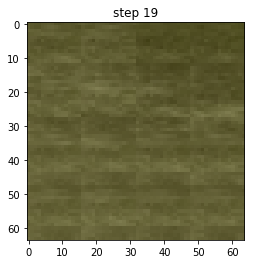

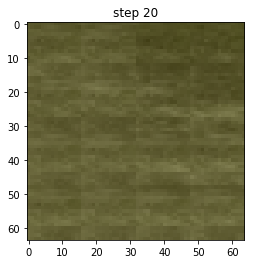

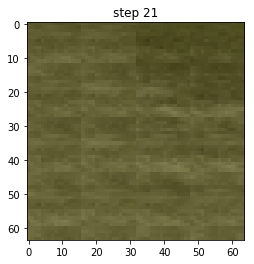

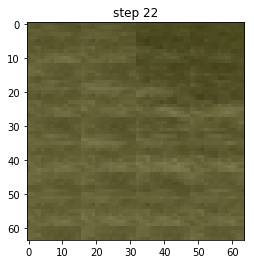

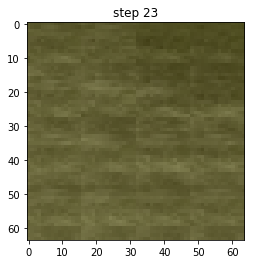

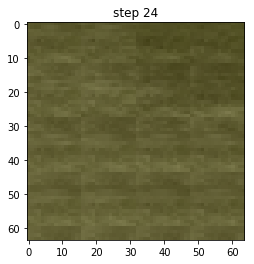

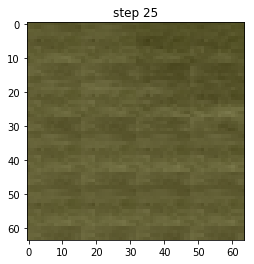

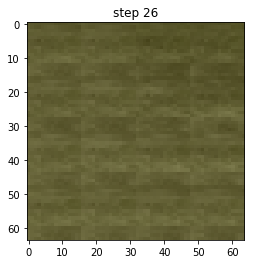

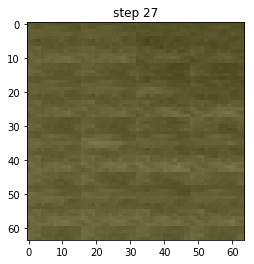

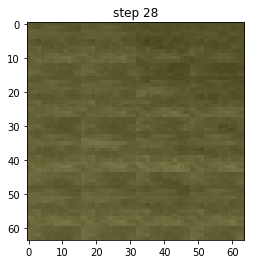

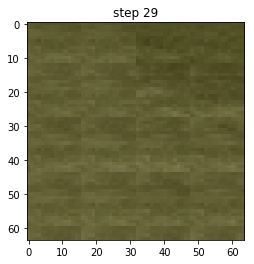

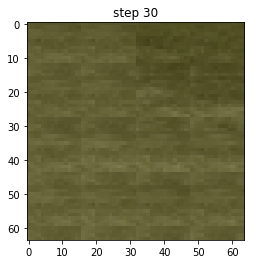

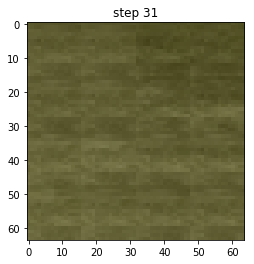

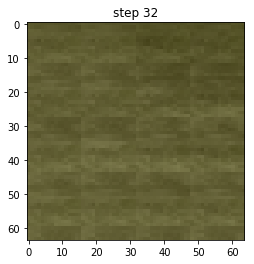

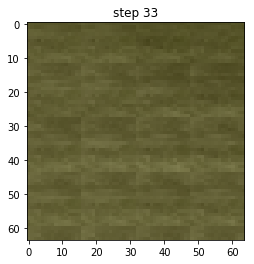

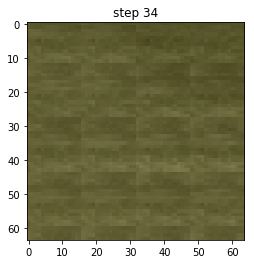

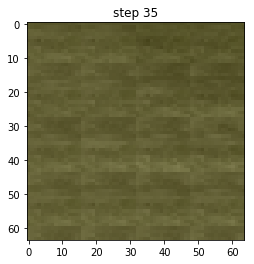

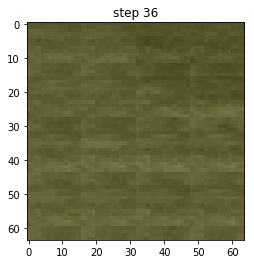

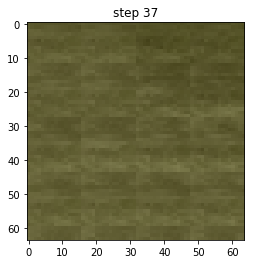

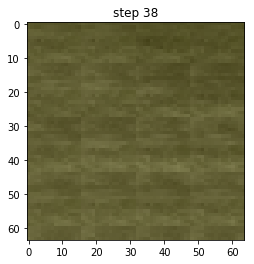

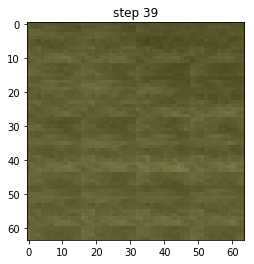

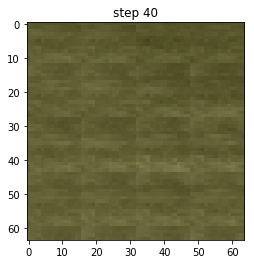

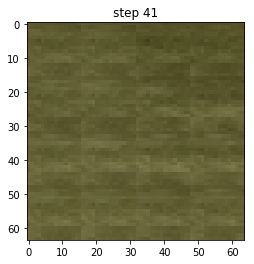

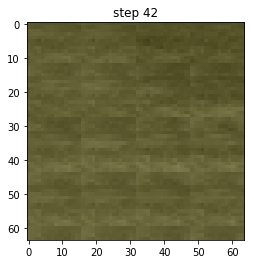

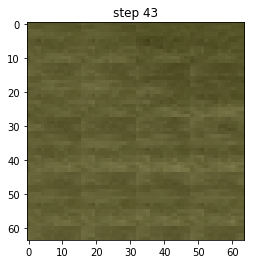

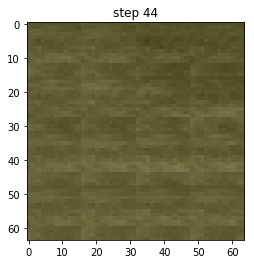

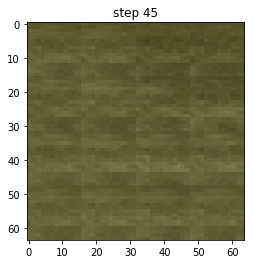

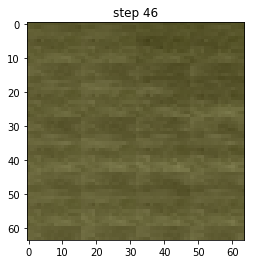

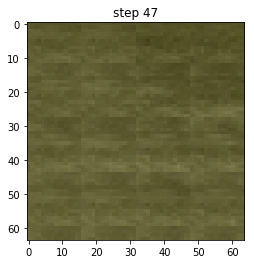

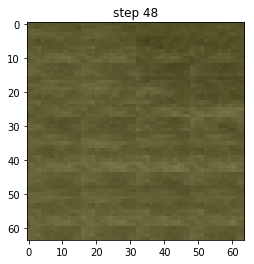

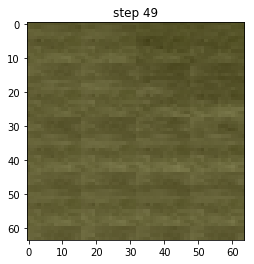

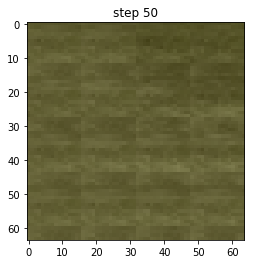

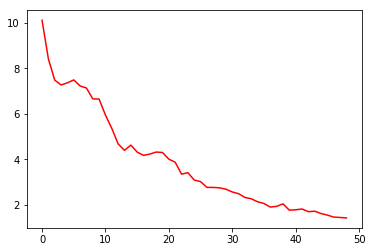

In [32]:
from google.colab import files

N_gen = 50
z = latent_variables[-dt:].unsqueeze(0)
latent_lstm.eval()
texture_type = texture_names[-1]

fold_save = './{}_lstm_generated/'.format(texture_type)

if not os.path.isdir(fold_save):
    os.mkdir(fold_save)
else:
    shutil.rmtree(fold_save)
    os.mkdir(fold_save)

gen = generate(latent_lstm, generator, z, N_gen = N_gen, save = True, fold_save = fold_save)        
plot_diff(gen)